
# Week 3 - Clustering & Topic Modeling

This week, we take a text corpus that we have developed, and we first break it into discrete document chunks through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of content clustering called topic modeling. This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. Finally, we will consider how to construct models that take document cluster and topic loading as predictive features.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [67]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'description', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [68]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [80]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


,category,source_file,text
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ..."
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom"
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not..."
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...


Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [81]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [82]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [83]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [84]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [85]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [86]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.046688020755456),
 ('certain', 0.1589865268627092),
 ('apple', 0.22685454684169398),
 ('13', 0.1411362504801527),
 ('rgb', 0.1817286448065436),
 ('monitors', 0.1619412292430009),
 ('there', 0.0749569030656185),
 ('has', 0.07484299310086841),
 ('been', 0.095991006908172),
 ('problem', 0.18819404816424326),
 ('with', 0.05464092321093494),
 ('the', 0.1109950967372947),
 ('high', 0.12601141569529475),
 ('voltage', 0.19706119834212132),
 ('capasitor', 0.242206441914102),
 ('knows', 0.16299450361806797),
 ('about', 0.15540750198460515),
 ('this', 0.05749878121929968),
 ('and', 0.04330392033255178),
 ('is', 0.04793741654764163)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [87]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [113]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [116]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [14]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [15]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [16]:
km.fit(newsgroupsTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [17]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'base', 'brier_score_loss', 'calinski_harabaz_score', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_log_error', 'median_absolute_error', 'mutual_info_score', 'normalized_mutual_info_score', 'pairwise', 'pairwise_distances', 'pairwise_distances_argmin', 'pairwise_distances_argmin_min', 'pairwise_fast', 'pairwise_kernels', 'precision_recall_cur

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [18]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

,category,source_file,text,kmeans_predictions
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ...",2
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...,2
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...,2
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom",2
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...,2
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David,2
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,2
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not...",2
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...,2
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...,2


We can also look at the distinguishing features in each cluster:

In [19]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 window
 server
 use
 motif
 using
 program
 widget
 application
 thanks
 code


Cluster 1:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 interested
 price
 email


Cluster 2:
 mac
 know
 drive
 just
 apple
 thanks
 like
 does
 don
 problem


Cluster 3:
 car
 cars
 engine
 like
 just
 good
 think
 don
 new
 dealer




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [20]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [21]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [22]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

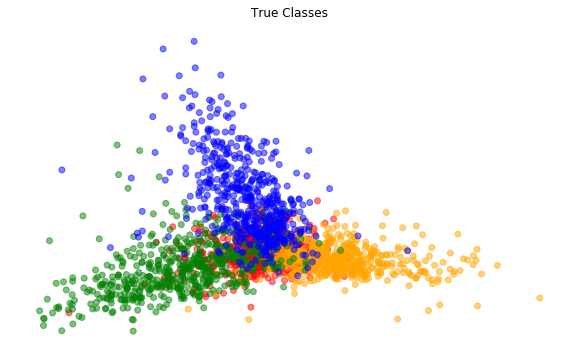

In [23]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

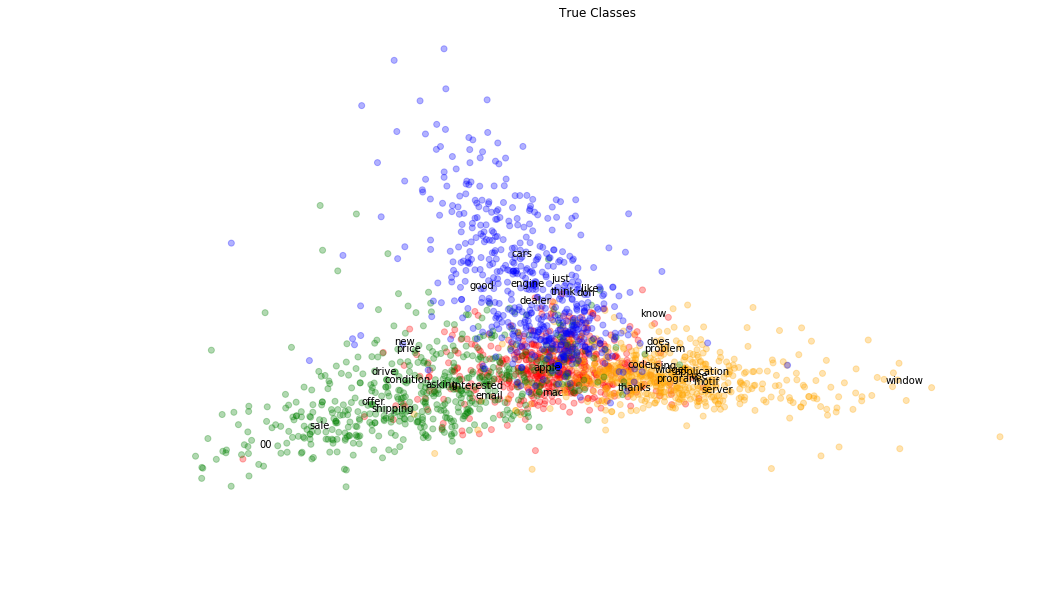

In [24]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [25]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

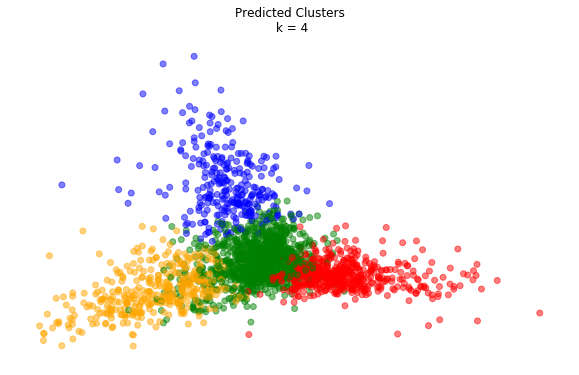

In [26]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [27]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [28]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters

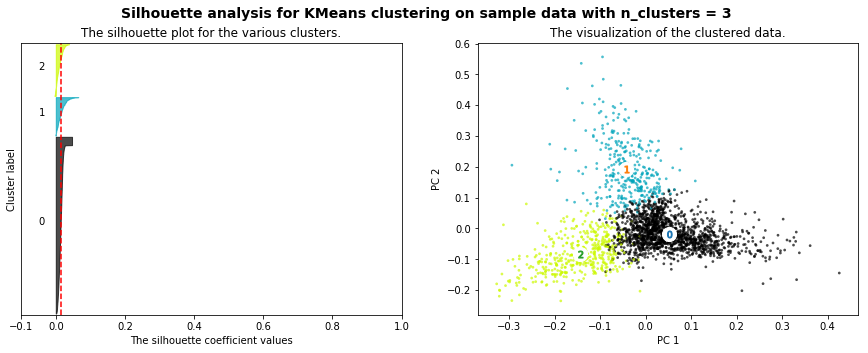

For n_clusters = 3, The average silhouette_score is : 0.014


In [29]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

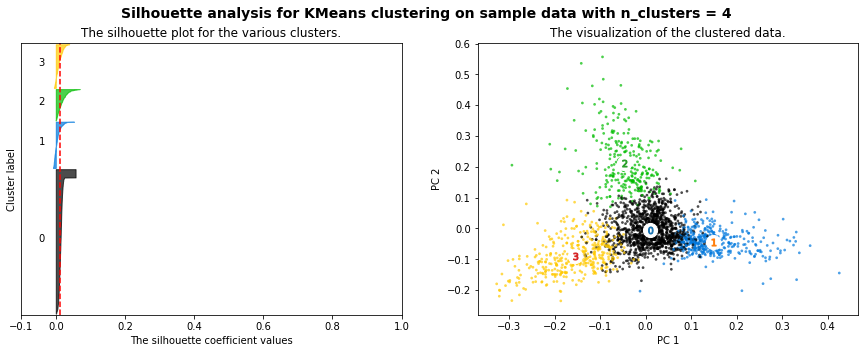

For n_clusters = 4, The average silhouette_score is : 0.012


In [30]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

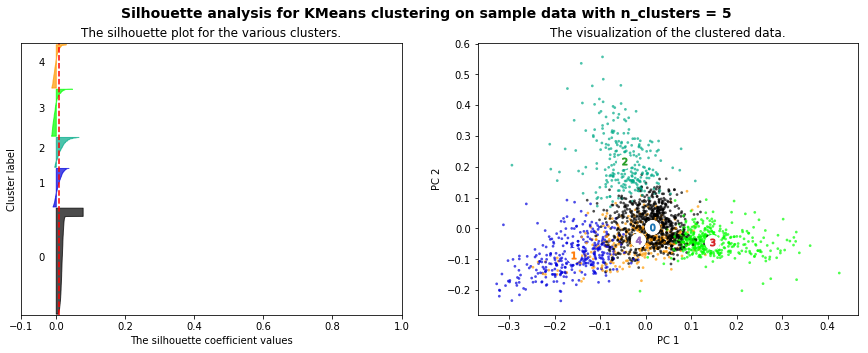

For n_clusters = 5, The average silhouette_score is : 0.010


In [31]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

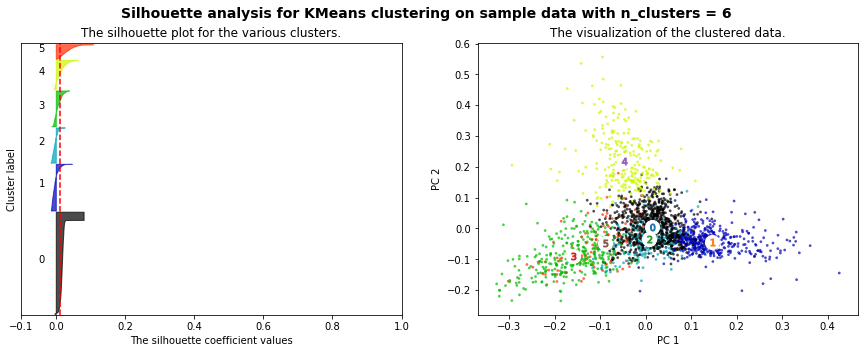

For n_clusters = 6, The average silhouette_score is : 0.011


In [32]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [285]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [286]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [287]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [191]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [192]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [193]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

And visualize:

In [39]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

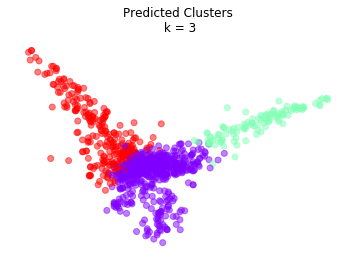

In [40]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters; with Silhouette analysis or maybe some of the metric although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [41]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,kmeans_predictions
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,2
1,1,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2005Kennedy12.txt,raw/Kennedy/01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,0
2,2,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy10.txt,raw/Kennedy/01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,2
3,3,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy11.txt,raw/Kennedy/01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
4,4,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy12.txt,raw/Kennedy/01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
5,5,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy13.txt,raw/Kennedy/01Aug2006Kennedy13.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
6,6,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2006Kennedy14.txt,raw/Kennedy/01Aug2006Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,0
7,7,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy5.txt,raw/Kennedy/01Aug2007Kennedy5.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,0
8,8,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy6.txt,raw/Kennedy/01Aug2007Kennedy6.txt,FOR IMMEDIATE RELEASE Rachel Racus...,Kennedy,2
9,9,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Aug2007Kennedy7.txt,raw/Kennedy/01Aug2007Kennedy7.txt,FOR IMMEDIATE RELEASE WASHINGTON DC...,Kennedy,2


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [43]:
import os.path
import os

In [179]:
Speeches_Data = '../Project_Data/DOSSpeeches' #I'm slowly working on creating my corpus
SpeechText = [] #As I develop my corpus, I have yet to clean all of my data
SpeechFileName = []
DOSSpeeches = ['DOS101016.txt', 'DOS052516.txt', 'DOS111016.txt', 'DOS091916.txt', 'DOS072915.txt']

for file in (file for file in os.scandir(targetDir) if file.is_file() and not file.name.startswith('.')):
    with open(file.path) as f:
        SpeechText.append(f.read())
    SpeechFileName.append(file.name)

SpeechesDF = pandas.DataFrame({'speech_title' : SpeechFileName, 'speech_text' : SpeechText}, index = SpeechFileName)
SpeechesDF

,speech_text,speech_title
DOS101016.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS101016.txt
DOS052516.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS052516.txt
DOS111016.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS111016.txt
DOS091916.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS091916.txt
DOS072915.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS072915.txt


In [180]:
SpeechesDF['tokenized_text'] = SpeechesDF['speech_text'].apply(lambda x: nltk.word_tokenize(x))
SpeechesDF['word_counts'] = SpeechesDF['tokenized_text'].apply(lambda x: len(x))
SpeechesDF['word_counts']

DOS101016.txt    1928
DOS052516.txt    5205
DOS111016.txt    5989
DOS091916.txt    1819
DOS072915.txt    1960
Name: word_counts, dtype: int64

In [249]:
SpeechesDF

,speech_text,speech_title,tokenized_text,word_counts,kmeans_predictions
DOS101016.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS101016.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",1928,0
DOS052516.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS052516.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",5205,4
DOS111016.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS111016.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",5989,2
DOS091916.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS091916.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",1819,1
DOS072915.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS072915.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",1960,3


In [76]:
SpeechesCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
SpeechesVects = SpeechesCountVectorizer.fit_transform(SpeechesDF['speech_text'])
print(SpeechesVects.shape)

(5, 2347)


In [77]:
SpeechesVects

<5x2347 sparse matrix of type '<class 'numpy.int64'>'
	with 4547 stored elements in Compressed Sparse Row format>

In [78]:
SpeechesVects[:10,:20].todense()

matrix([[ 2,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  2,  0,  4,
          0,  0,  0,  0],
        [ 0,  0,  3,  1,  1,  1,  0,  0,  0,  1,  1,  1,  0,  5,  2, 13,
          6,  0,  1,  1],
        [ 0,  1,  0,  0,  0,  0,  1,  0,  2,  0,  0,  1,  6,  3,  3,  3,
          2,  0,  0,  0],
        [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  0,  4,
          1,  0,  0,  2],
        [ 0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  1,  2,
          0,  1,  0,  0]])

In [79]:
SpeechesCountVectorizer.vocabulary_.get('cyber')

601

In [89]:
SpeechesTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(SpeechesVects)
SpeechesTF = SpeechesTFTransformer.transform(SpeechesVects)
print(SpeechesTF.shape)

(5, 2347)


In [93]:
list(zip(SpeechesCountVectorizer.vocabulary_.keys(), SpeechesTF.data))[:20]

[('rtf1', 0.0058163260123317686),
 ('ansi', 0.0058163260123317686),
 ('ansicpg1252', 0.0058163260123317686),
 ('cocoartf1561', 0.0058163260123317686),
 ('cocoasubrtf100', 0.0058163260123317686),
 ('fonttbl', 0.0058163260123317686),
 ('f0', 0.011632652024663537),
 ('fswiss', 0.0068767676257212714),
 ('fcharset0', 0.0058163260123317686),
 ('helvetica', 0.0068767676257212714),
 ('colortbl', 0.0058163260123317686),
 ('red255', 0.011632652024663537),
 ('green255', 0.011632652024663537),
 ('blue255', 0.011632652024663537),
 ('red23', 0.0068767676257212714),
 ('green38', 0.0068767676257212714),
 ('blue64', 0.0068767676257212714),
 ('expandedcolortbl', 0.0058163260123317686),
 ('cssrgb', 0.011632652024663537),
 ('c11765', 0.0068767676257212714)]

In [114]:
SpeechesTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.2, max_features=1000, min_df=1, stop_words='english',)
SpeechesTFVects = SpeechesTFVectorizer.fit_transform(SpeechesDF['speech_text'])

In [115]:
SpeechesTFVects

<5x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 1000 stored elements in Compressed Sparse Row format>

In [118]:
try:
    print(SpeechesTFVectorizer.vocabulary_['cyber'])
except KeyError:
    print('cyber is missing')
    print('The available words are: {} ...'.format(list(SpeechesTFVectorizer.vocabulary_.keys())[:20]))

cyber is missing
The available words are: ['levelnfc0', 'levelnfcn0', 'decimal', '00', 'listtemplateid2', 'leveltemplateid101', 'listid2', 'ls2', 'morning', 'prime', 'minister', 'lee', 'worth', '25', 'th', 'anniversary', 'premier', 'amazing', 'wows', 'speaker'] ...


In [ ]:
#I realize I have to clean the data in order to get more significant results

In [ ]:
#Below I will attempt Flat Clustering with k-means

In [144]:
SpnumClusters = len(set(SpeechesDF['speech_title']))
SpnumClusters

5

In [145]:
km = sklearn.cluster.KMeans(n_clusters=SpnumClusters, init='k-means++')

In [146]:
km.fit(SpeechesTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [147]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("for our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(SpeechesDF['speech_title'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(SpeechesDF['speech_title'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(SpeechesDF['speech_title'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'base', 'brier_score_loss', 'calinski_harabaz_score', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_log_error', 'median_absolute_error', 'mutual_info_score', 'normalized_mutual_info_score', 'pairwise', 'pairwise_distances', 'pairwise_distances_argmin', 'pairwise_distances_argmin_min', 'pairwise_fast', 'pairwise_kernels', 'precision_recall_cur

In [186]:
SpeechesDF['kmeans_predictions'] = km.labels_
SpeechesDF

,speech_text,speech_title,tokenized_text,word_counts,kmeans_predictions
DOS101016.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS101016.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",1928,0
DOS052516.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS052516.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",5205,4
DOS111016.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS111016.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",5989,2
DOS091916.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS091916.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",1819,1
DOS072915.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS072915.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",1960,3


In [148]:
#I realize that these results are not very insightful, my apologies as I work through this exercise

In [150]:
terms = SpeechesTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(SpnumClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 ls2
 vital
 represented
 listid2
 decimal
 large
 lee
 levelnfc0
 levelnfcn0
 00


Cluster 1:
 channels
 membership
 modern
 institutions
 coordinate
 senate
 negotiate
 conviction
 needed
 hangzhou


Cluster 2:
 countermeasures
 responsibility
 koh
 remarks
 circumstances
 operation
 generally
 does
 customary
 publicly


Cluster 3:
 arf
 regard
 workshop
 agenda
 resolution
 stewards
 operating
 tasks
 norm
 trends


Cluster 4:
 i0
 cf0
 counter
 osce
 dialogue
 subcommittee
 threat
 policies
 deterring
 senior




In [151]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(SpeechesTFVects.toarray())
reduced_data = pca.transform(SpeechesTFVects.toarray())

In [172]:
components = pca.components_
keyword_threat = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
print (keyword_threat)
words = [terms[threat] for threat in keyword_threat]#Turn the ids into words.
x = components[:,keyword_threat][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_threat][1,:]

[0, 131, 388, 905, 522, 778, 779, 893, 536, 408, 540, 672, 547, 294, 296, 302, 432, 305, 564, 565, 441, 442, 570, 317, 450, 706, 457, 458, 842, 972, 332, 721, 209, 853, 215, 471, 729, 219, 605, 480, 993, 737, 103, 360, 745, 359, 363, 879, 504, 381]


In [173]:
colordict = {
'DOS052516.txt': 'red',
'DOS072915.txt': 'orange',
'DOS091916.txt': 'green',
'DOS101016.txt': 'blue',
'DOS111016.txt': 'yellow',
    }
colors = [colordict[c] for c in SpeechesDF['speech_title']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('DOS052516.txt', 'red'), ('DOS072915.txt', 'orange'), ('DOS091916.txt', 'green'), ('DOS101016.txt', 'blue'), ('DOS111016.txt', 'yellow')])


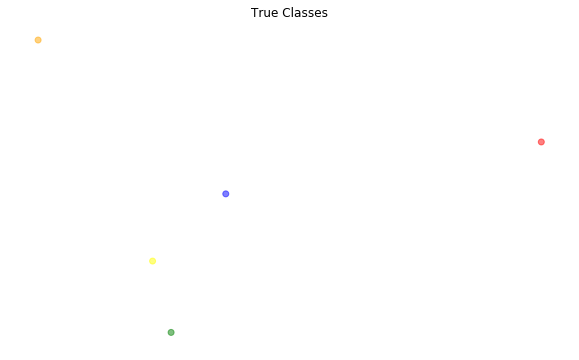

In [176]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

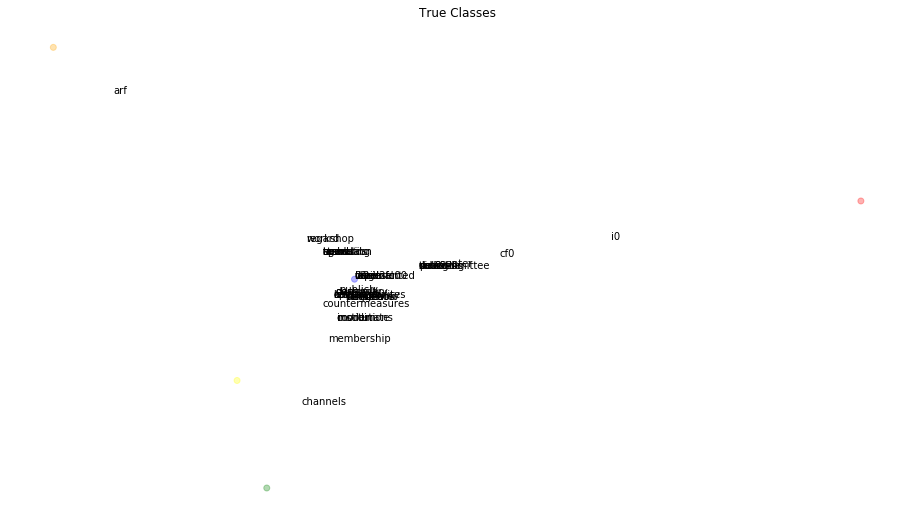

In [177]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [181]:
colors_p = [colordict[DOSSpeeches[l]] for l in km.labels_]

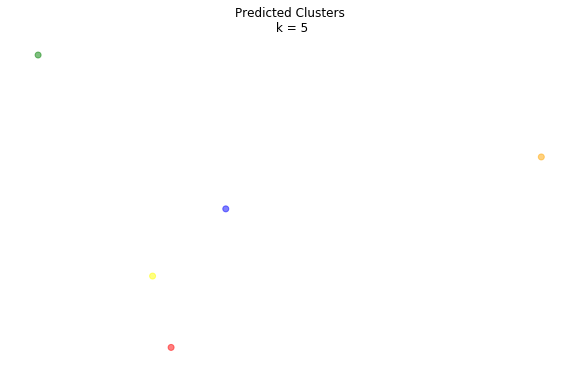

In [183]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 5')
plt.show()

In [184]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(SpeechesTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
#Section on Selecting Cluster Number

In [185]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

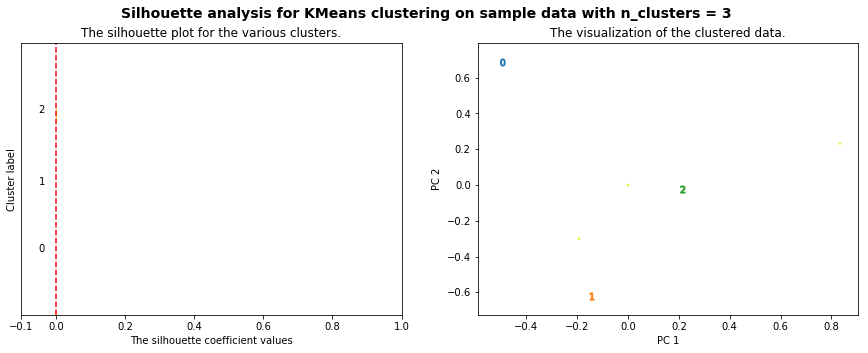

For n_clusters = 3, The average silhouette_score is : -0.000


In [187]:
X = SpeechesTFVects.toarray()
plotSilhouette(3, X)

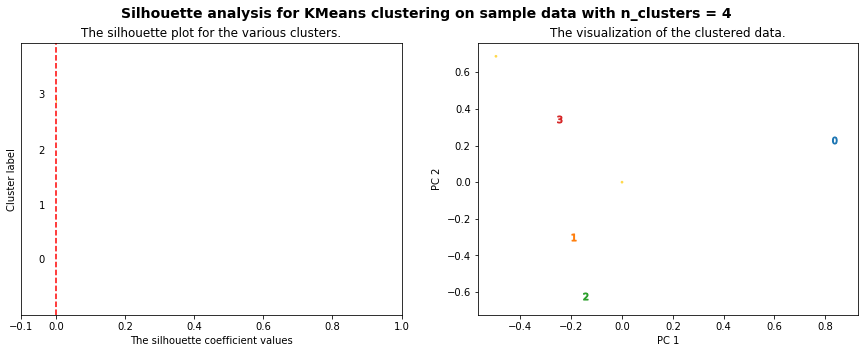

For n_clusters = 4, The average silhouette_score is : -0.000


In [188]:
X = SpeechesTFVects.toarray()
plotSilhouette(4, X)

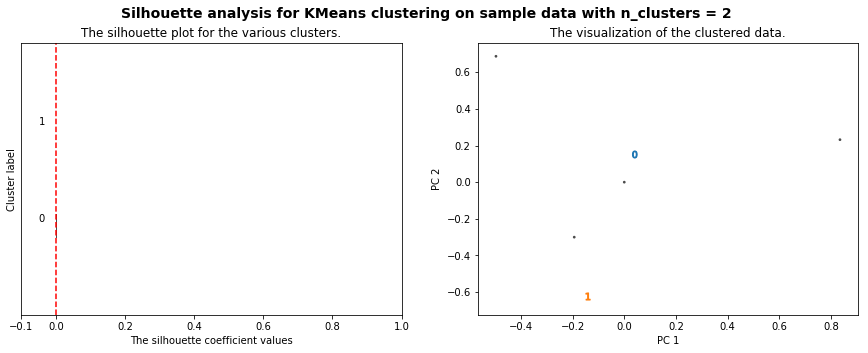

For n_clusters = 2, The average silhouette_score is : 0.000


In [190]:
X = SpeechesTFVects.toarray()
plotSilhouette(2, X)

In [ ]:
#I realize that one of the problems I need to address for this to be more insightful is having a broader data set

In [196]:
Speeches2TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
Speeches2TFVects = Speeches2TFVectorizer.fit_transform(SpeechesDF['speech_text'])
Speeches2TFVectorizer.vocabulary_.get('cyber', 'cyberspace')

238

In [198]:
textColumn = 'speech_text'
numCategories = 3
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = SpeechesTFVectorizer.fit_transform(SpeechesDF[textColumn])

In [199]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [200]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

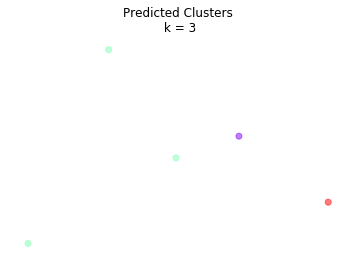

In [201]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [202]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [203]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [204]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:742: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [205]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [206]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [207]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 93.        ,  95.        ,   0.        ,   2.        ],
       [ 98.        , 200.        ,   0.        ,   3.        ],
       [126.        , 201.        ,   0.        ,   4.        ],
       [  5.        , 202.        ,   0.37033177,   5.        ],
       [ 69.        , 104.        ,   0.40914841,   2.        ],
       [ 10.        ,  44.        ,   0.44134524,   2.        ],
       [ 49.        ,  62.        ,   0.45096656,   2.        ],
       [ 51.        , 204.        ,   0.4553535 ,   3.        ],
       [117.        , 206.        ,   0.4650683 ,   3.        ],
       [  2.        ,  46.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

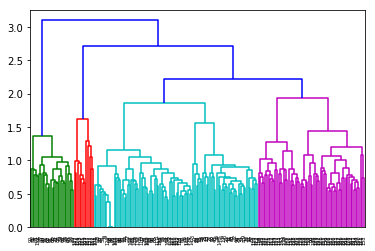

In [208]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

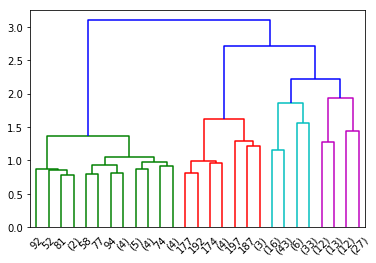

In [209]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [210]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1,
       1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3,
       4, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 1, 4,
       4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4, 3, 2, 2, 2,
       4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4, 4, 4, 4, 2,
       4, 3], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [211]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [212]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

,category,source_file,text,wald_predictions
0,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\tIn certain Apple 13"" RGB monitors there has ...",4
1,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Does anyone know how to reach Micron? I am in...,4
2,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,Hi there!\n\nCould some kind soul tell me what...,4
3,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"""auto\nfrom",4
4,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n Don't believe the hype. There is no su...,4
5,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,What is the value of an SE (HDFD) 4/20?\n\n-David,4
6,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...,4
7,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,"\n\n\n Nope. The Apple 16"" monitor does not...",4
8,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\nIs it a hidden option? I'm using PowerStr...,3
9,comp.sys.mac.hardware,../data/scikit_learn_data/20news_home/20news-b...,\n\n\nThe previous article referred to the fac...,4


# Now let's do it with our new data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [222]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


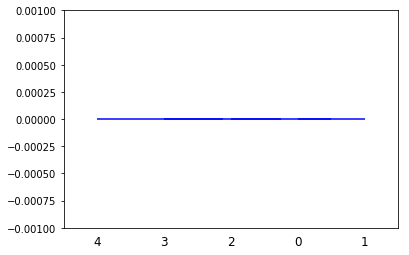

In [223]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [224]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


As we only used one senator for this there isn't any point in looking at the metrics, but you should if possible

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

In [225]:
SpeechesCoocMat = SpeechesTFVects * SpeechesTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
SpeechesCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


In [244]:
SpeechesTFVects[:100].todense()

matrix([[0.14359163, 0.        , 0.        , ..., 0.07179582, 0.        ,
         0.07179582],
        [0.        , 0.09515422, 0.03171807, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.02253602,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [255]:
selectIndices = []
indexToCat = []
for c in set(SpeechesDF['speech_text']):
    selectIndices += list(SpeechesDF[SpeechesDF['speech_text'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('speech_text').sum()

In [257]:
SubCoocMat = SpeechesCoocMat[selectIndices,:][:,selectIndices]

IndexError: invalid index

In [258]:
link_matrix = scipy.cluster.hierarchy.ward(SpeechesCoocMat[:100, :100].toarray())
link_matrix[:10]

/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[0., 1., 0., 2.],
       [2., 5., 0., 3.],
       [3., 6., 0., 4.],
       [4., 7., 0., 5.]])

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


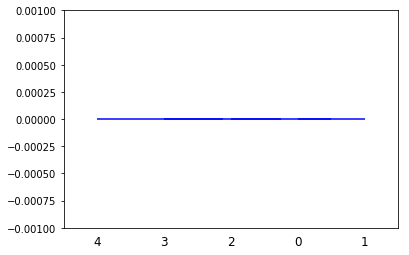

In [259]:
ax = scipy.cluster.hierarchy.dendrogram(link_matrix)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


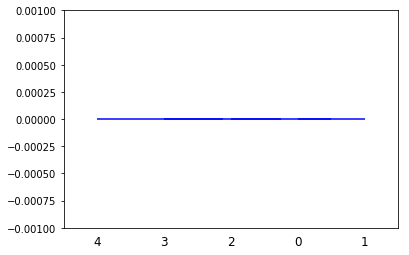

In [260]:
ax = scipy.cluster.hierarchy.dendrogram(link_matrix, p=4, truncate_mode='level')

In [261]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(link_matrix, 4, 'maxclust')
hierarchicalClusters

array([1, 1, 1, 1, 1], dtype=int32)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


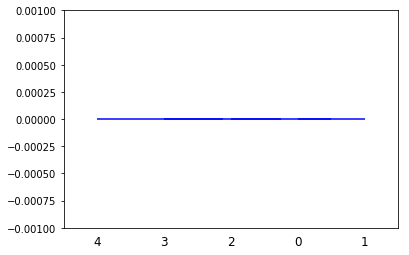

In [262]:
dendDat = scipy.cluster.hierarchy.dendrogram(link_matrix, get_leaves=True)

In [ ]:
#Did not work with the first part of the code, will attempt with code for new data

In [268]:
SpeechesCoocMat = SpeechesTFVects * SpeechesTFVects.T
SpeechesCoocMat.setdiag(0)
Speecheslinkage_matrix = scipy.cluster.hierarchy.ward(SpeechesCoocMat[:100, :100].toarray())

/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


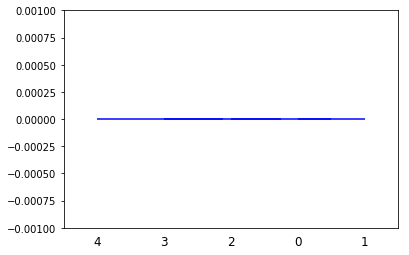

In [269]:
ax = scipy.cluster.hierarchy.dendrogram(Speecheslinkage_matrix, p=5, truncate_mode='level')

In [270]:
Speeches_linkage_matrix_full = scipy.cluster.hierarchy.ward(SpeechesCoocMat.toarray())
Speeches_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(Speeches_linkage_matrix_full, 4, 'maxclust')

/anaconda3/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [271]:
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(SpeechesDF['speech_text'], Speeches_hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(SpeechesDF['speech_text'], Speeches_hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(SpeechesDF['speech_text'], Speeches_hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(SpeechesDF['speech_text'], Speeches_hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Score: 0.000


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


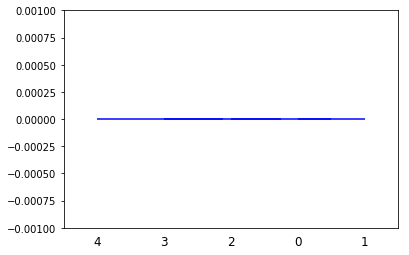

In [272]:
dendDat = scipy.cluster.hierarchy.dendrogram(Speecheslinkage_matrix, get_leaves=True)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


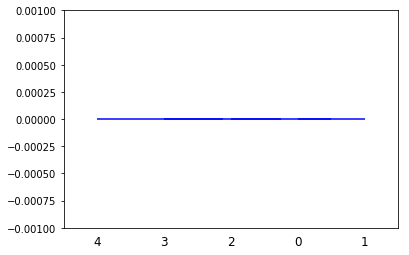

In [273]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(Speecheslinkage_matrix, p=4, truncate_mode='level', get_leaves=True)

In [274]:
SpeechesDF['wald_predictions'] = Speeches_hierarchicalClusters_full
SpeechesDF

,speech_text,speech_title,tokenized_text,word_counts,kmeans_predictions,wald_predictions
DOS101016.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS101016.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",1928,0,1
DOS052516.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS052516.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",5205,4,1
DOS111016.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS111016.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",5989,2,1
DOS091916.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS091916.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",1819,1,1
DOS072915.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS072915.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",1960,3,1


# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [288]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: nltk.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))
senReleasesTraining[::100]

,Unnamed: 0,download_url,html_url,name,path,text,targetSenator,tokenized_text,normalized_tokens
0,0,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,01Apr2005Kennedy14.txt,raw/Kennedy/01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, contact, meli..."
100,101,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,02Feb2006Kennedy8.txt,raw/Kennedy/02Feb2006Kennedy8.txt,FOR IMMEDIATE RELEASE Washington DC...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
200,201,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,04May2006Kennedy7.txt,raw/Kennedy/04May2006Kennedy7.txt,FOR IMMEDIATE RELEASE FOR IMMEDI...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, washington, c..."
300,301,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,06Jun2006Kennedy5.txt,raw/Kennedy/06Jun2006Kennedy5.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, surpris, amer..."
400,401,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,08Dec2006Kennedy4.txt,raw/Kennedy/08Dec2006Kennedy4.txt,FOR IMMEDIATE RELEASE Washington D ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, D, C, To...","[immedi, releas, washington, c, today, senat, ..."
500,501,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,09Nov2005Kennedy10.txt,raw/Kennedy/09Nov2005Kennedy10.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
600,601,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,11Nov2005Kennedy5.txt,raw/Kennedy/11Nov2005Kennedy5.txt,FOR IMMEDIATE RELEASE On this Vet...,Kennedy,"[FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...","[immedi, releas, veteran, day, america, stand,..."
700,701,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,13Jun2006Kennedy0.txt,raw/Kennedy/13Jun2006Kennedy0.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...","[immedi, releas, immedi, releas, mr, chairman,..."
800,801,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,15Dec2005Kennedy4.txt,raw/Kennedy/15Dec2005Kennedy4.txt,FOR IMMEDIATE RELEASE Washington ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...","[immedi, releas, washington, dc, today, senat,..."
900,901,https://raw.githubusercontent.com/lintool/Grim...,https://github.com/lintool/GrimmerSenatePressR...,16May2007Kennedy10.txt,raw/Kennedy/16May2007Kennedy10.txt,FOR IMMEDIATE RELEASE WASHINGTON D ...,Kennedy,"[FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...","[immedi, releas, washington, c, senat, edward,..."


In [289]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [290]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [291]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [292]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [293]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [294]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(6, 0.9691211)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [295]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [296]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,01Aug2005Kennedy12.txt,"[(0, 0.95702136)]",0.957021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
101,02Feb2007Kennedy10.txt,"[(4, 0.84461313), (5, 0.14879636)]",0.000000,0.000000,0.000000,0.000000,0.844613,0.148796,0.000000,0.000000,0.0,0.000000
201,04May2006Kennedy8.txt,"[(1, 0.5803046), (2, 0.4171137)]",0.000000,0.580305,0.417114,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
301,06Jun2007Kennedy1.txt,"[(1, 0.23838072), (2, 0.6029448), (7, 0.156557...",0.000000,0.238381,0.602945,0.000000,0.000000,0.000000,0.000000,0.156557,0.0,0.000000
401,08Feb2005Kennedy0.txt,"[(4, 0.46680886), (6, 0.49505717), (9, 0.02991...",0.000000,0.000000,0.000000,0.000000,0.466809,0.000000,0.495057,0.000000,0.0,0.029917
501,09Nov2005Kennedy11.txt,"[(5, 0.9399908)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.939991,0.000000,0.000000,0.0,0.000000
601,11Nov2005Kennedy6.txt,"[(3, 0.95945776)]",0.000000,0.000000,0.000000,0.959458,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
701,13Jun2006Kennedy1.txt,"[(1, 0.19510485), (2, 0.030392254), (4, 0.7397...",0.000000,0.195105,0.030392,0.000000,0.739710,0.000000,0.000000,0.032163,0.0,0.000000
801,15Dec2005Kennedy5.txt,"[(3, 0.3345946), (5, 0.38427356), (6, 0.277399)]",0.000000,0.000000,0.000000,0.334595,0.000000,0.384274,0.277399,0.000000,0.0,0.000000
901,16May2007Kennedy5.txt,"[(3, 0.95770377)]",0.000000,0.000000,0.000000,0.957704,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [297]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.969121,0.0,0.000000,0.0
1,0.957021,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.991199,0.0
3,0.000000,0.0,0.000000,0.000000,0.037871,0.000000,0.000000,0.0,0.954740,0.0
4,0.000000,0.0,0.370866,0.040555,0.000000,0.586217,0.000000,0.0,0.000000,0.0
5,0.000000,0.0,0.990753,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
6,0.000000,0.0,0.000000,0.600283,0.383906,0.000000,0.000000,0.0,0.000000,0.0
7,0.000000,0.0,0.000000,0.011975,0.955250,0.000000,0.000000,0.0,0.000000,0.0
8,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.994864,0.0
9,0.965890,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0


First we can visualize as a stacked bar chart:

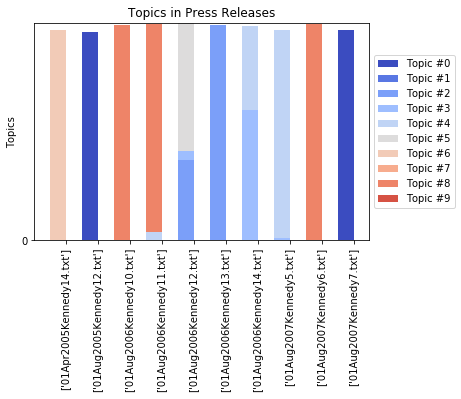

In [298]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

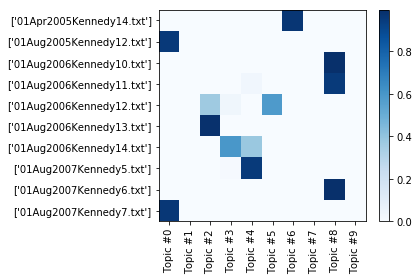

In [299]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [300]:
senlda.show_topic(1)

[('wagon', 0.008149262),
 ('depart', 0.0073591033),
 ('amend', 0.006616486),
 ('unit', 0.0065037045),
 ('senior', 0.005642802),
 ('import', 0.00563607),
 ('fund', 0.0054625324),
 ('author', 0.0053771683),
 ('troop', 0.005244126),
 ('concern', 0.004798112)]

And if we want to make a dataFrame:

In [301]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,loan,wagon,wage,worker,worker,worker,fund,fund,loan,mental
1,lender,depart,minimum,fund,import,fund,head,troop,lender,fund
2,rate,amend,worker,pension,fda,govern,worker,import,depart,worker
3,wagon,unit,employ,depart,wagon,depart,victim,author,attorney,wagon
4,worker,senior,govern,import,govern,head,wagon,wagon,unit,import
5,import,import,hour,save,fund,wagon,assist,armor,wagon,depart
6,fund,fund,amend,commit,minimum,author,parent,amend,worker,govern
7,amend,author,unit,wagon,wage,assist,teacher,unit,govern,ill
8,borrow,troop,import,unit,loan,inform,employ,depart,rate,treatment
9,inform,concern,wagon,author,troop,import,import,commit,inform,inform


We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

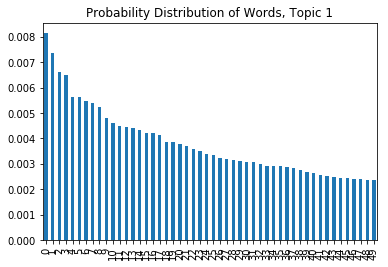

In [302]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [303]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

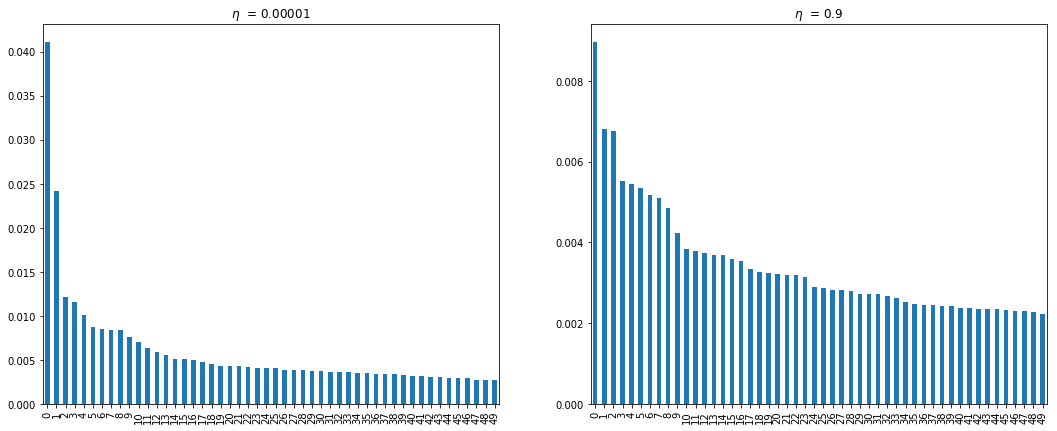

In [304]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [305]:
SpeechesDF['tokenized_text'] = SpeechesDF['speech_text'].apply(lambda x: nltk.word_tokenize(x))
SpeechesDF['normalized_tokens'] = SpeechesDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, 
                                                                                                                            stopwordLst = lucem_illud.stop_words_basic, 
                                                                                                                            stemmer = lucem_illud.stemmer_basic))
SpeechesDF

,speech_text,speech_title,tokenized_text,word_counts,kmeans_predictions,wald_predictions,normalized_tokens
DOS101016.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS101016.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",1928,0,1,"[helvetica, good, morn, thank, prime, minist, ..."
DOS052516.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS052516.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",5205,4,1,"[chairman, gardner, rank, member, cardin, memb..."
DOS111016.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS111016.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",5989,2,1,"[helvetica, thank, saira, kind, introduct, tha..."
DOS091916.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS091916.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",1819,1,1,"[helvetica, chairman, donilon, vice, chairman,..."
DOS072915.txt,{\rtf1\ansi\ansicpg1252\cocoartf1561\cocoasubr...,DOS072915.txt,"[{, \rtf1\ansi\ansicpg1252\cocoartf1561\cocoas...",1960,3,1,"[helvetica, thank, opportun, discuss, develop,..."


In [306]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

SpeechesDF['reduced_tokens'] = SpeechesDF['normalized_tokens'].apply(lambda x: dropMissing(x, SpeechesTFVectorizer.vocabulary_.keys()))

In [307]:
dictionary = gensim.corpora.Dictionary(SpeechesDF['reduced_tokens'])


In [308]:
corpus = [dictionary.doc2bow(text) for text in SpeechesDF['reduced_tokens']]


In [309]:
gensim.corpora.MmCorpus.serialize('speeches.mm', corpus)
speechesmm = gensim.corpora.MmCorpus('speeches.mm')

In [312]:
speecheslda = gensim.models.ldamodel.LdaModel(corpus=speechesmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [313]:
speeches1Bow = dictionary.doc2bow(SpeechesDF['reduced_tokens'][0])
speeches1lda = speecheslda[speeches1Bow]
print("The topics of the text: {}".format(SpeechesDF['speech_title'][0]))
print("are: {}".format(speeches1lda))

The topics of the text: DOS101016.txt
are: [(9, 0.9879857)]


In [314]:
SpeechesldaDF = pandas.DataFrame({
        'name' : SpeechesDF['speech_title'],
        'topics' : [speecheslda[dictionary.doc2bow(l)] for l in SpeechesDF['reduced_tokens']]
    })

In [318]:
SpeechestopicsProbDict = {i : [0] * len(SpeechesldaDF) for i in range(speecheslda.num_topics)}

for index, topicTuples in enumerate(SpeechesldaDF['topics']):
    for topicNum, prob in topicTuples:
        SpeechestopicsProbDict[topicNum][index] = prob

for topicNum in range(speecheslda.num_topics):
    SpeechesldaDF['topic_{}'.format(topicNum)] = SpeechestopicsProbDict[topicNum]

SpeechesldaDF

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
DOS101016.txt,DOS101016.txt,"[(9, 0.9879836)]",0.00000,0.000000,0,0,0,0.00000,0,0.000000,0,0.987984
DOS052516.txt,DOS052516.txt,"[(9, 0.9947994)]",0.00000,0.000000,0,0,0,0.00000,0,0.000000,0,0.994799
DOS111016.txt,DOS111016.txt,"[(1, 0.88589466), (7, 0.11088087)]",0.00000,0.885895,0,0,0,0.00000,0,0.110881,0,0.000000
DOS091916.txt,DOS091916.txt,"[(0, 0.98391044)]",0.98391,0.000000,0,0,0,0.00000,0,0.000000,0,0.000000
DOS072915.txt,DOS072915.txt,"[(5, 0.98462)]",0.00000,0.000000,0,0,0,0.98462,0,0.000000,0,0.000000


In [320]:
SpeechesldaDFV = SpeechesldaDF[:10][['topic_%d' %x for x in range(10)]]
SpeechesldaDFVisN = SpeechesldaDF[:10][['name']]
SpeechesldaDFVis = SpeechesldaDFV.as_matrix(columns=None)
SpeechesldaDFVisNames = SpeechesldaDFVisN.as_matrix(columns=None)
SpeechesldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
DOS101016.txt,0.00000,0.000000,0,0,0,0.00000,0,0.000000,0,0.987984
DOS052516.txt,0.00000,0.000000,0,0,0,0.00000,0,0.000000,0,0.994799
DOS111016.txt,0.00000,0.885895,0,0,0,0.00000,0,0.110881,0,0.000000
DOS091916.txt,0.98391,0.000000,0,0,0,0.00000,0,0.000000,0,0.000000
DOS072915.txt,0.00000,0.000000,0,0,0,0.98462,0,0.000000,0,0.000000


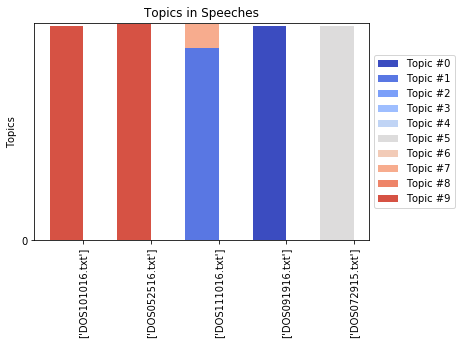

In [322]:
N = 5
ind = np.arange(N)
K = speecheslda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, SpeechesldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, SpeechesldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += SpeechesldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Speeches')
plt.xticks(ind+width/2, SpeechesldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

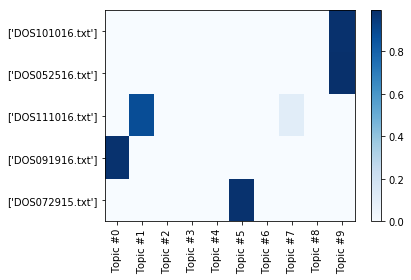

In [323]:
plt.pcolor(SpeechesldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(SpeechesldaDFVis.shape[0])+0.5, SpeechesldaDFVisNames);
plt.xticks(np.arange(SpeechesldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [324]:
speecheslda.show_topic(1)

[('norm', 0.05530065),
 ('koh', 0.017795794),
 ('manual', 0.015939012),
 ('lead', 0.015494839),
 ('arf', 0.014615368),
 ('turn', 0.014054966),
 ('project', 0.013856304),
 ('access', 0.012884924),
 ('want', 0.012629624),
 ('threshold', 0.012098808)]

In [325]:
SpeechestopicsDict = {}
for topicNum in range(speecheslda.num_topics):
    topicWords = [w for w, p in speecheslda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

SpeecheswordRanksDF = pandas.DataFrame(topicsDict)
SpeecheswordRanksDF


,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,partner,norm,norm,norm,norm,arf,norm,norm,threat,threat
1,channel,koh,koh,manual,threat,norm,project,threat,norm,norm
2,assist,manual,threshold,project,affirm,threat,threshold,partner,partner,affirm
3,threat,lead,lead,koh,assist,partner,lead,affirm,affirm,partner
4,norm,arf,fall,threshold,regard,workshop,manual,regard,assist,regard
5,membership,turn,manual,turn,cost,protect,avail,assist,close,assist
6,secret,project,avail,access,counter,secret,koh,element,regard,cost
7,element,access,harold,avail,partner,affirm,restrict,connect,connect,counter
8,affirm,want,connect,harold,pose,agenda,turn,close,vital,close
9,modern,threshold,restrict,restrict,element,regard,want,counter,ask,vital


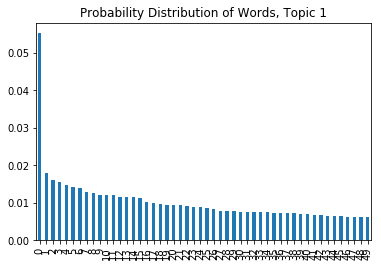

In [328]:
Speechestopic1_df = pandas.DataFrame(speecheslda.show_topic(1, topn=50))
plt.figure()
Speechestopic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

In [330]:
speecheslda1 = gensim.models.ldamodel.LdaModel(corpus=speechesmm, id2word=dictionary, num_topics=10, eta = 0.00001)
speecheslda2 = gensim.models.ldamodel.LdaModel(corpus=speechesmm, id2word=dictionary, num_topics=10, eta = 0.9)

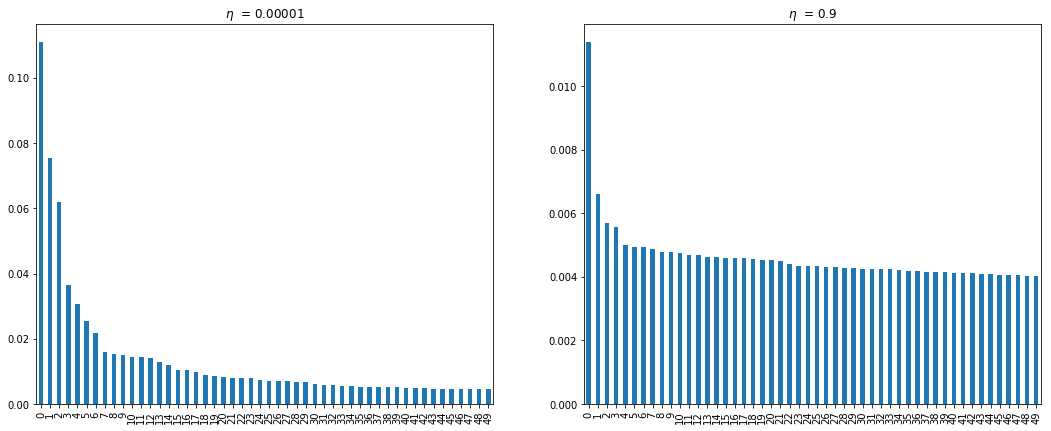

In [331]:
Speechestopic11_df = pandas.DataFrame(speecheslda1.show_topic(1, topn=50))
Speechestopic21_df = pandas.DataFrame(speecheslda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
Speechestopic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
Speechestopic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

Moving forward, I hope to first expand on my corpus to include all DOS speeches from the archive, and clean the data within it. Once I have been able to do that, I hope to narrow down some of these methods to relate them to cyber. 